<div align=\"center\"><h1> Project Pricing Autocall SG </h1></div>

## About the product Autocall SG

## Implementation of pricing autocall 

### Import libraries

In [242]:
import time
import datetime
from math import sqrt, exp, log
from random import gauss
import scipy.stats
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [251]:
%matplotlib inline

In [261]:
# definition of function

def BS(S_t, v, r):
    return S_t* exp(( r - 0.5 * v**2)/252 + v *sqrt(1/252) * np.random.normal(0,1))

def generate_asset_price(S_t,v,r,t1,t2):
    # S is spot price
    # V is implied vol
    T= (t2- t1).days/365.0
    return S_t * exp((r - 0.5 * v**2) * T + v * sqrt(T) * gauss(0,1.0))

def df(r,t1,t2): 
    # function of discount factor between date t1 and t2 with interest rate r
    return exp(-r * (t2-t1).days/365.0)
    

### Import date

In [278]:
tabDate = pd.read_csv('date.csv', sep= ";", infer_datetime_format= True)

In [286]:
date= [datetime.datetime.strptime(x, '%m/%d/%Y') for x in list(tabDate.date)]

In [280]:
start_date = date[0]
end_date = date[-1]

In [288]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = pd.to_datetime(cal.holidays(start=start_date, end=end_date))

In [289]:
from datetime import timedelta

def daterange(date1, date2):
    date_range = [date1]
    for n in range(int ((date2 - date1).days)+1):
        date_next =  date1 + timedelta(n)
        if (date_next not in holidays) and (date_next.weekday() < 5):
            date_range.append(date_next)
    return date_range

In [328]:
#np.random.seed(123)
v= 0.20 # Implied volatility
r = 0.05 # taux d'interet
class oneSimulationMC:
    def __init__(self, start_date, end_date):
        self.start_date = start_date
        self.end_date = end_date
    
    def generate_prices(self):
        df = pd.DataFrame(daterange(self.start_date, self.end_date), columns= ['date'])
        df.set_index('date', inplace= True)
        df['prix'] = 100
        for i in range(1, df.size):
            df.prix[i] = BS(df.prix[i-1], v, r).astype(np.float)
        return df    
    
    def priceAtDate(self,dt):
        return self.generate_prices().iloc[dt]

In [329]:
date[1]

datetime.datetime(2013, 5, 7, 0, 0)

In [337]:
df = oneSimulationMC(start_date, end_date).generate_prices()

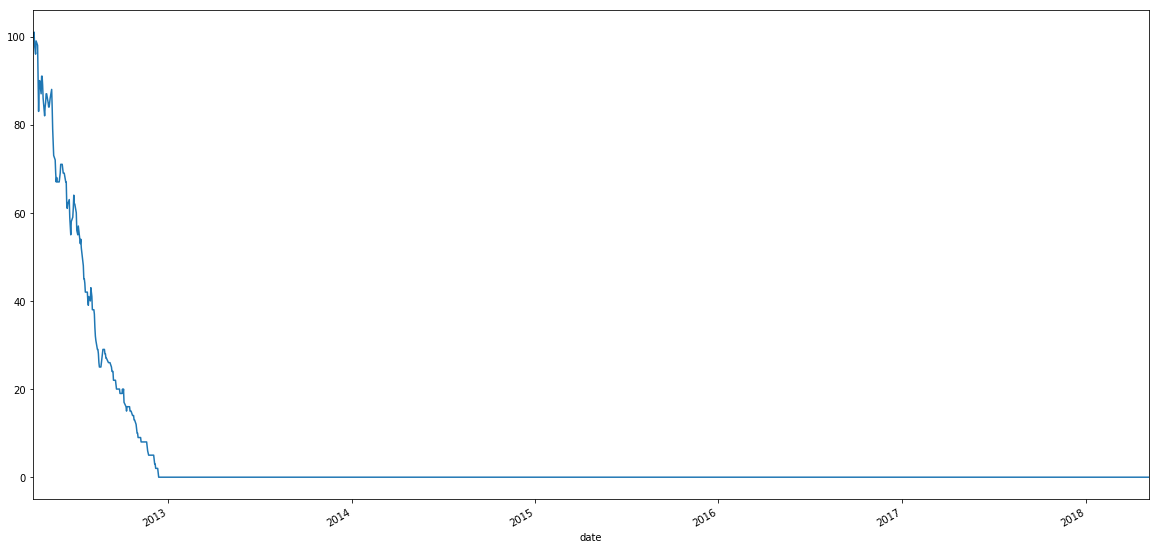

In [338]:
df.prix.plot(figsize= (20,10))

## Monte Carlo Simulation

In [59]:
S =100 # asset price at the start date
v= 0.20 # Implied volatility
r = 0.05 # taux d'interet
N = 1000 # initial investment

l = len(date)
asset_prices = [S] * l
coupon_barrier = 0.8
kickout_barrier = 1.1
protection_barrier = 0.6
coupon_rate = 0.088
autocall_prices= []

In [60]:
def mcSimulation(simulations):
    start_date = date[0]
    end_date = date[-1]
    for i in range(simulations):
        autocall_price = 0
        checker = True
        payoffs = [0] * l # on remet tous les payoffs a zero
        #Le payoff a la start_date vaut toujours zero

        for j in range(1, l- 1) :
            asset_prices[j]= generate_asset_price(asset_prices[j-1],v,r,date[j-1],date[j])/S
            if asset_prices[j] < coupon_barrier:
                payoffs[j+1] = payoffs[j]+ N * coupon_rate
                payoffs[j] = 0
                autocall_price += payoffs[j] * df(r,start_date,date[j])
            elif asset_prices[j] < kickout_barrier:
                payoffs[j] += N * coupon_rate
                autocall_price += payoffs[j]  * df(r,start_date,date[j])
            else:
                payoffs[j] += N * coupon_rate + N
                autocall_price += payoffs[j] * df(r,start_date,date[j])
                checker = False
                break

        if checker: 
            if asset_prices[-1] < protection_barrier:
                payoffs[-1] = N * asset_prices[l -1]
            elif asset_prices[-1] < coupon_barrier: 
                payoffs[-1] = N
            else:
                payoffs[-1] += N * coupon_rate + N

        autocall_prices.append(autocall_price)

    final_autocall_price = sum(autocall_prices)/float(simulations)
    return final_autocall_price

In [61]:
mcSimulation(1000000)

434.7566342504829